<a href="https://colab.research.google.com/github/TanzilaDewan789/BT_Classification/blob/main/btc_gnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Install Graph Neural Network library
!pip install torch-geometric

# Import basic libraries (file operations, image processing, data processing, visualization)
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from math import gamma
from tqdm import tqdm  # progress bar

# Import TensorFlow and pretrained model InceptionV3 (for image feature extraction)
import tensorflow as tf
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.models import Model
from tensorflow.keras.applications.inception_v3 import preprocess_input

# Import machine learning tools (data splitting and label encoding)
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# Import PyTorch and Graph Neural Network related modules
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.data import Data  # graph data structure
from torch_geometric.loader import DataLoader  # graph data loader
from torch_geometric.nn import GCNConv, global_mean_pool  # graph convolution layer and pooling
import random

# Set all random seeds to ensure reproducible results
np.random.seed(42)
torch.manual_seed(42)
tf.random.set_seed(42)
random.seed(42)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.7/63.7 kB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 20.7 MB/s eta 0:00:00


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("masoudnickparvar/brain-tumor-mri-dataset")

print("Path to dataset files:", path)

Using Colab cache for faster access to the 'brain-tumor-mri-dataset' dataset.
Path to dataset files: /kaggle/input/brain-tumor-mri-dataset


In [ ]:
# Data Loading
print("Loading training dataset...")
data_train = []
base_dir_train = "/kaggle/input/brain-tumor-mri-dataset/Training"

# Traverse the training directory and collect all jpg image paths and labels
for dirname, _, filenames in os.walk(base_dir_train):
    label = os.path.basename(dirname)  # Folder name used as label (e.g., "glioma", "meningioma", etc.)
    for filename in filenames:
        if filename.endswith(".jpg"):
            filepath = os.path.join(dirname, filename)
            data_train.append([filepath, label])  # Store image path and corresponding label

# Convert the list into a DataFrame for easier processing later
df_train = pd.DataFrame(data_train, columns=["filepath", "label"])

print("Loading testing dataset...")
data_test = []
base_dir_test = "/kaggle/input/brain-tumor-mri-dataset/Testing"

# Process the testing dataset in the same way
for dirname, _, filenames in os.walk(base_dir_test):
    label = os.path.basename(dirname)
    for filename in filenames:
        if filename.endswith(".jpg"):
            filepath = os.path.join(dirname, filename)
            data_test.append([filepath, label])

df_test = pd.DataFrame(data_test, columns=["filepath", "label"])

# Print basic dataset information
print("Train:", df_train.shape, "Test:", df_test.shape)  # Show dataset dimensions (rows, columns)
print("Training labels:", df_train['label'].value_counts())  # Show the number of samples per class in training set
print("Testing labels:", df_test['label'].value_counts())  # Show class distribution in the test set

Loading training dataset...
Loading testing dataset...
Train: (5712, 2) Test: (1311, 2)
Training labels: label
notumor       1595
pituitary     1457
meningioma    1339
glioma        1321
Name: count, dtype: int64
Testing labels: label
notumor       405
meningioma    306
pituitary     300
glioma        300
Name: count, dtype: int64


In [ ]:
print(df_train.shape)
print(df_train.head())

(5712, 2)
                                            filepath      label
0  /kaggle/input/brain-tumor-mri-dataset/Training...  pituitary
1  /kaggle/input/brain-tumor-mri-dataset/Training...  pituitary
2  /kaggle/input/brain-tumor-mri-dataset/Training...  pituitary
3  /kaggle/input/brain-tumor-mri-dataset/Training...  pituitary
4  /kaggle/input/brain-tumor-mri-dataset/Training...  pituitary


In [ ]:
# Split the training data into training and validation sets
df_train_small, df_valid = train_test_split(
    df_train,                    # Original training data
    test_size=0.2,               # Use 20% as validation set
    random_state=42,             # Random seed to ensure reproducibility
    stratify=df_train['label']   # Stratified sampling to maintain class balance
)

# Print final dataset sizes
print(f"Final splits - Train: {df_train_small.shape}, Valid: {df_valid.shape}, Test: {df_test.shape}")

Final splits - Train: (4569, 2), Valid: (1143, 2), Test: (1311, 2)


In [ ]:
# Feature extraction setup
print("Setting up feature extractor...")

# Load the pretrained InceptionV3 model, remove the top classification layer, and specify input size
base_model = InceptionV3(weights="imagenet", include_top=False, input_shape=(299, 299, 3))

# Add a global average pooling layer after the base model output to convert feature maps into feature vectors
avg_pool = tf.keras.layers.GlobalAveragePooling2D()(base_model.output)

# Create the feature extraction model — input is the original model input, output is the pooled feature vector
feature_extractor = Model(inputs=base_model.input, outputs=avg_pool)

Setting up feature extractor...
87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [ ]:
def extract_features(df, feature_extractor, img_size=(299, 299)):
    """Use InceptionV3 to extract features from images"""
    features = []  # Store feature vectors
    labels = []    # Store corresponding labels

    # Iterate through each row in the DataFrame, showing a progress bar
    for idx, row in tqdm(df.iterrows(), total=len(df), desc="Extracting features"):
        try:
            # Load image
            img = cv2.imread(row['filepath'])
            if img is None:  # Check if image loaded successfully
                print(f"Could not load image: {row['filepath']}")
                continue

            # Image preprocessing
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB
            img = cv2.resize(img, img_size)             # Resize image
            img = np.expand_dims(img, axis=0)           # Add batch dimension
            img = preprocess_input(img)                 # Apply InceptionV3 preprocessing

            # Extract features
            feature = feature_extractor.predict(img, verbose=0)  # Predict to obtain features
            feature = feature.flatten()                 # Flatten into 1D vector

            # Save results
            features.append(feature)
            labels.append(row['label'])

        except Exception as e:
            print(f"Error processing {row['filepath']}: {e}")
            continue

    return np.array(features), labels  # Return feature array and label list

In [ ]:
# Extract features for all datasets
print("Extracting features from training data...")
train_features, train_labels = extract_features(df_train_small, feature_extractor)

print("Extracting features from validation data...")
valid_features, valid_labels = extract_features(df_valid, feature_extractor)

print("Extracting features from test data...")
test_features, test_labels = extract_features(df_test, feature_extractor)

# Encode labels (convert text labels into numeric values)
label_encoder = LabelEncoder()
train_labels_encoded = label_encoder.fit_transform(train_labels)  # Fit and transform training labels
valid_labels_encoded = label_encoder.transform(valid_labels)      # Transform validation labels
test_labels_encoded = label_encoder.transform(test_labels)        # Transform test labels

# Print result information
print(f"Classes: {label_encoder.classes_}")  # Display all class names
print(f"Train features shape: {train_features.shape}")  # Training feature dimensions
print(f"Valid features shape: {valid_features.shape}")  # Validation feature dimensions
print(f"Test features shape: {test_features.shape}")    # Test feature dimensions

Extracting features from training data...


Extracting features: 100%|██████████| 4569/4569 [08:54<00:00,  8.55it/s]


Extracting features from validation data...


Extracting features: 100%|██████████| 1143/1143 [02:16<00:00,  8.38it/s]


Extracting features from test data...


Extracting features: 100%|██████████| 1311/1311 [02:36<00:00,  8.36it/s]

Classes: ['glioma' 'meningioma' 'notumor' 'pituitary']
Train features shape: (4569, 2048)
Valid features shape: (1143, 2048)
Test features shape: (1311, 2048)


In [ ]:
def create_simple_graphs(features, labels):
    """Create simple single-node graphs (with self-loops)"""
    graphs = []

    for i in range(len(features)):
        # Single-node graph – each graph has only one node
        x = torch.tensor(features[i:i+1], dtype=torch.float)  # Node feature
        # Self-loop edge – node connected to itself
        edge_index = torch.tensor([[0], [0]], dtype=torch.long)  # Edge index
        y = torch.tensor([labels[i]], dtype=torch.long)  # Graph label

        graph = Data(x=x, edge_index=edge_index, y=y)
        graphs.append(graph)

    return graphs


def create_knn_graphs(features, labels, k=5):
    """Create K-nearest neighbor (KNN) graphs – each image connects to its k most similar neighbors"""
    graphs = []

    for i in range(len(features)):
        # Compute distances to all other images (Euclidean distance)
        distances = np.sum((features - features[i]) ** 2, axis=1)
        nearest_indices = np.argsort(distances)[:k+1]  # The k+1 closest neighbors (including itself)

        # Create node features (self + k nearest neighbors)
        selected_features = features[nearest_indices]
        x = torch.tensor(selected_features, dtype=torch.float)

        # Create edges – central node (0) connects to all neighbor nodes
        sources = [0] * k  # k source nodes (all are central node 0)
        targets = list(range(1, k+1))  # k target nodes (neighbors 1 to k)
        edge_index = torch.tensor([sources + targets, targets + sources], dtype=torch.long)

        # Label for the central node
        y = torch.tensor([labels[i]], dtype=torch.long)

        graph = Data(x=x, edge_index=edge_index, y=y)
        graphs.append(graph)

    return graphs

In [ ]:
# Create graph structures
print("Creating graph structures...")
# Use the simple graph method (single node + self-loop) to create graphs for each dataset
train_graphs = create_simple_graphs(train_features, train_labels_encoded)
valid_graphs = create_simple_graphs(valid_features, valid_labels_encoded)
test_graphs = create_simple_graphs(test_features, test_labels_encoded)

# Print the number of created graphs
print(f"Created {len(train_graphs)} training graphs")
print(f"Created {len(valid_graphs)} validation graphs")
print(f"Created {len(test_graphs)} test graphs")

# Create data loaders
train_loader = DataLoader(train_graphs, batch_size=16, shuffle=True)  # Shuffle training set
valid_loader = DataLoader(valid_graphs, batch_size=16)  # Do not shuffle validation set
test_loader = DataLoader(test_graphs, batch_size=16)    # Do not shuffle test set

Creating graph structures...
Created 4569 training graphs
Created 1143 validation graphs
Created 1311 test graphs


In [ ]:
# Define the GNN model
class EnhancedGNN(nn.Module):
    def __init__(self, in_feats=2048, hidden=256, num_classes=4, dropout=0.3, num_layers=3):
        super().__init__()

        self.convs = nn.ModuleList()
        self.bns = nn.ModuleList()

        # Input layer
        self.convs.append(GCNConv(in_feats, hidden))
        self.bns.append(nn.BatchNorm1d(hidden))

        # Hidden layers
        for i in range(num_layers - 1):
            self.convs.append(GCNConv(hidden, hidden))
            self.bns.append(nn.BatchNorm1d(hidden))

        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(hidden, num_classes)
        self.num_layers = num_layers

    def forward(self, x, edge_index, batch):
        # Multi-layer graph convolution
        for i in range(self.num_layers):
            x = self.convs[i](x, edge_index)
            x = self.bns[i](x)
            x = F.relu(x)
            x = self.dropout(x)

        # Global pooling + classification
        x = global_mean_pool(x, batch)
        return self.fc(x)

In [ ]:
def train_one_epoch(model, loader, optimizer, criterion):
    model.train()  # Set model to training mode
    total_loss = 0
    for batch in loader:
        optimizer.zero_grad()  # Clear gradients
        out = model(batch.x, batch.edge_index, batch.batch)  # Forward pass
        loss = criterion(out, batch.y)  # Compute loss
        loss.backward()  # Backpropagation
        optimizer.step()  # Update parameters
        total_loss += loss.item()  # Accumulate loss
    return total_loss / len(loader)  # Return average loss


def evaluate(model, loader):
    model.eval()  # Set model to evaluation mode
    correct = 0
    total = 0
    with torch.no_grad():  # Disable gradient calculation
        for batch in loader:
            out = model(batch.x, batch.edge_index, batch.batch)  # Forward pass
            preds = out.argmax(dim=1)  # Get predicted classes
            correct += (preds == batch.y).sum().item()  # Count correct predictions
            total += batch.y.size(0)  # Count total samples
    return correct / total  # Return accuracy

In [ ]:
# Initialize model for testing
model = EnhancedGNN()  # Create GNN model instance
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)  # Use Adam optimizer
criterion = nn.CrossEntropyLoss()  # Use cross-entropy loss function

# Quick initial training test
print("Running initial training test...")
for epoch in range(3):  # Train for only 3 epochs for testing
    train_loss = train_one_epoch(model, train_loader, optimizer, criterion)  # Train one epoch
    val_acc = evaluate(model, valid_loader)  # Evaluate on validation set
    print(f"Epoch {epoch+1}, Train Loss={train_loss:.4f}, Val Acc={val_acc:.4f}")  # Print results

In [ ]:
# PSO Optimization
print("Setting up PSO hyperparameter optimization...")

# Define hyperparameter search space
param_space = {
    "hidden_dim": (128, 1024),      # Expanded search range, allowing larger networks
    "lr": (1e-5, 1e-2),             # Wider learning rate range
    "dropout": (0.1, 0.6),          # Adjusted dropout range
    "num_layers": (2, 4)            # Added: search over number of layers
}

pso_control_params = {
    "CF1_range": (1.9, 2.1),  # Inertia weight range
    "use_chaotic_initialization": True,
    "use_adaptive_weights": True,
    "use_levy_flight": True,
    "chaos_type": "logistic"  # Options: 'logistic', 'tent', 'trigonometric'
}

def enhanced_objective(params, epochs=3):
    """Enhanced objective function that considers training stability and convergence speed"""
    hidden_dim, lr, dropout, num_layers = params

    # Use the enhanced model
    model = EnhancedGNN(
        in_feats=2048,
        hidden=int(hidden_dim),
        num_classes=len(label_encoder.classes_),
        dropout=dropout,
        num_layers=int(num_layers)
    )
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=1e-4)  # Use AdamW optimizer
    criterion = nn.CrossEntropyLoss()

    train_losses = []
    best_val_acc = 0

    # Train and monitor stability
    for epoch in range(epochs):
        epoch_loss = 0
        model.train()
        for batch in train_loader:
            optimizer.zero_grad()
            out = model(batch.x, batch.edge_index, batch.batch)
            loss = criterion(out, batch.y)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)  # Gradient clipping
            optimizer.step()
            epoch_loss += loss.item()

        train_losses.append(epoch_loss / len(train_loader))

        # Validate every epoch and keep best accuracy
        val_acc = evaluate(model, valid_loader)
        if val_acc > best_val_acc:
            best_val_acc = val_acc

    # Penalize unstable training (loss fluctuation)
    loss_std = np.std(train_losses[-2:]) if len(train_losses) >= 2 else 0
    stability_penalty = loss_std * 0.1

    return best_val_acc - stability_penalty


def enhanced_chaotic_map(size, map_type='logistic', current_iter=0, max_iters=10):
    """Enhanced chaotic mapping function supporting multiple chaotic systems"""
    chaos_seq = np.zeros(size)

    if map_type == 'logistic':
        # Logistic map
        chaos_seq[0] = np.random.random()
        mu = 4.0  # Fully chaotic state
        for i in range(1, size):
            chaos_seq[i] = mu * chaos_seq[i-1] * (1 - chaos_seq[i-1])

    elif map_type == 'tent':
        # Tent map
        chaos_seq[0] = np.random.random()
        for i in range(1, size):
            if chaos_seq[i-1] < 0.5:
                chaos_seq[i] = 2 * chaos_seq[i-1]
            else:
                chaos_seq[i] = 2 * (1 - chaos_seq[i-1])

    elif map_type == 'trigonometric':
        # Trigonometric oscillation chaotic map
        chaos_seq[0] = np.random.random()
        for i in range(1, size):
            chaos_seq[i] = np.sin(np.pi * chaos_seq[i-1])

    # Adaptive chaotic strength (decreases over iterations)
    adaptive_factor = 1.0 - (current_iter / max_iters) * 0.5
    chaos_seq = chaos_seq * adaptive_factor

    return chaos_seq


# === Adaptive inertia weight function ===
def adaptive_inertia_weight(current_iter, max_iters, weight_type='exp_decay'):
    """Adaptive inertia weight calculation"""
    if weight_type == 'exp_decay':
        # Exponential decay
        numerator = np.exp(current_iter / max_iters) - 1
        denominator = np.exp(1) - 1
        term = (numerator / denominator) ** (1/1.5)
        CF1 = 2.1 - 0.2 * term

    elif weight_type == 'frac_decay':
        # Fractional exponential decay — precompute full sequence range
        J = max_iters
        j_values = np.arange(J)
        f1_sequence = 2 * (1 - j_values/J) ** 0.4

        current_f1 = 2 * (1 - current_iter/J) ** 0.4

        a, b = 1.9, 2.1
        min_val = np.min(f1_sequence)
        max_val = np.max(f1_sequence)
        k = (b - a) / (max_val - min_val)
        CF1 = a + k * (current_f1 - min_val)

    elif weight_type == 'triangle_osc':
        # Triangular oscillation — precompute sequence range
        T = max_iters
        t_values = np.arange(T)
        f1_sequence = 3 - np.abs((0.5 * t_values - 1) * np.pi / (T - 1)) ** 0.5

        current_f1 = 3 - np.abs((0.5 * current_iter - 1) * np.pi / (T - 1)) ** 0.5

        a, b = 1.9, 2.1
        min_val = np.min(f1_sequence)
        max_val = np.max(f1_sequence)
        k = (b - a) / (max_val - min_val)
        CF1 = a + k * (current_f1 - min_val)

    else:
        # Default linear decay
        CF1 = 0.9 - (0.9 - 0.4) * current_iter / max_iters

    return np.clip(CF1, 1.9, 2.1)


# Lévy flight function
def levy_flight(beta=1.5, size=1):
    """Generate Lévy flight step size"""
    sigma_u = (gamma(1 + beta) * np.sin(np.pi * beta / 2) /
               (gamma((1 + beta) / 2) * beta * (2 ** ((beta - 1) / 2)))) ** (1 / beta)

    u = np.random.normal(0, sigma_u, size)
    v = np.random.normal(0, 1, size)
    step = u / (np.abs(v) ** (1 / beta))

    return step


# Enhanced particle class
class EnhancedParticle:
    def __init__(self, bounds, use_chaos=True, chaos_type='logistic', current_iter=0, max_iters=10):
        self.chaos_type = chaos_type
        self.current_iter = current_iter
        self.max_iters = max_iters

        if use_chaos:
            chaos_seq = enhanced_chaotic_map(4, chaos_type, current_iter, max_iters)
            self.position = [
                bounds["hidden_dim"][0] + chaos_seq[0] * (bounds["hidden_dim"][1] - bounds["hidden_dim"][0]),
                10**(np.log10(bounds["lr"][0]) + chaos_seq[1] * (np.log10(bounds["lr"][1]) - np.log10(bounds["lr"][0]))),
                bounds["dropout"][0] + chaos_seq[2] * (bounds["dropout"][1] - bounds["dropout"][0]),
                int(bounds["num_layers"][0] + chaos_seq[3] * (bounds["num_layers"][1] - bounds["num_layers"][0]))
            ]
        else:
            self.position = [
                random.randint(bounds["hidden_dim"][0], bounds["hidden_dim"][1]),
                10**random.uniform(np.log10(bounds["lr"][0]), np.log10(bounds["lr"][1])),
                random.uniform(bounds["dropout"][0], bounds["dropout"][1]),
                random.randint(bounds["num_layers"][0], bounds["num_layers"][1])
            ]

        self.velocity = [0, 0, 0, 0]
        self.best_position = self.position[:]
        self.best_score = -1.0
        self.chaos_strength = 1.0 - (current_iter / max_iters) * 0.8  # Chaotic intensity decays over iterations

Setting up PSO hyperparameter optimization...


In [ ]:
# === Replace with the enhanced PSO function ===
def advanced_PSO(num_particles=10, max_iters=10, use_chaos=True, use_levy=True, weight_type='exp_decay'):
    """Advanced PSO algorithm integrating chaotic mapping and adaptive parameters"""
    swarm = [EnhancedParticle(param_space, use_chaos=use_chaos, chaos_type=pso_control_params["chaos_type"])
             for _ in range(num_particles)]

    global_best = None
    global_best_score = -1.0

    # Adaptive parameter settings
    c1_max, c1_min = 2.0, 1.0
    c2_max, c2_min = 2.0, 1.0

    # Elite retention
    elite_size = max(2, num_particles // 5)

    # Record convergence curve
    convergence_curve = []

    for it in range(max_iters):
        # Adaptively adjust parameters
        w = adaptive_inertia_weight(it, max_iters, weight_type)
        c1 = c1_max - (c1_max - c1_min) * it / max_iters
        c2 = c2_min + (c2_max - c2_min) * it / max_iters

        print(f"\n--- Advanced PSO Iteration {it+1}/{max_iters} ---")
        print(f"Adaptive params: w={w:.3f}, c1={c1:.3f}, c2={c2:.3f}")

        # Evaluate all particles
        scores = []
        for i, particle in enumerate(swarm):
            # Update the particle's current iteration info
            particle.current_iter = it
            particle.max_iters = max_iters

            print(f"Evaluating Particle {i+1}: hidden={int(particle.position[0])}, lr={particle.position[1]:.6f}, dropout={particle.position[2]:.3f}, layers={int(particle.position[3])}")
            score = enhanced_objective(particle.position, epochs=2)
            print(f"  Score: {score:.4f}")
            scores.append(score)

            if score > particle.best_score:
                particle.best_score = score
                particle.best_position = particle.position[:]

            if score > global_best_score:
                global_best_score = score
                global_best = particle.position[:]

        convergence_curve.append(global_best_score)

        # Elite selection: keep the best particles
        elite_indices = np.argsort(scores)[-elite_size:]
        elite_particles = [swarm[i] for i in elite_indices]

        # Update particles (elite particles are kept as-is)
        for i, particle in enumerate(swarm):
            if i not in elite_indices:
                # Learn from global best and personal best
                for d in range(len(particle.position)):
                    r1, r2 = random.random(), random.random()

                    particle.velocity[d] = (
                        w * particle.velocity[d] +
                        c1 * r1 * (particle.best_position[d] - particle.position[d]) +
                        c2 * r2 * (global_best[d] - particle.position[d])
                    )

                    # Chaotic perturbation
                    if use_chaos and random.random() < particle.chaos_strength:
                        chaos_step = enhanced_chaotic_map(1, particle.chaos_type, it, max_iters)[0]
                        param_names = list(param_space.keys())
                        param_range = param_space[param_names[d]]
                        chaos_magnitude = 0.1 * (1 - it/max_iters)  # Chaotic amplitude decays
                        particle.velocity[d] += chaos_magnitude * chaos_step * (param_range[1] - param_range[0])

                    particle.position[d] += particle.velocity[d]

                    # Lévy flight perturbation
                    if use_levy and random.random() < 0.1:
                        levy_step = levy_flight(beta=1.3, size=1)[0]
                        param_names = list(param_space.keys())
                        param_range = param_space[param_names[d]]
                        particle.position[d] += 0.05 * levy_step * (param_range[1] - param_range[0])

                    # Boundary constraints
                    if d == 0:
                        particle.position[d] = int(np.clip(particle.position[d], *param_space["hidden_dim"]))
                    elif d == 1:
                        particle.position[d] = float(np.clip(particle.position[d], *param_space["lr"]))
                    elif d == 2:
                        particle.position[d] = float(np.clip(particle.position[d], *param_space["dropout"]))
                    elif d == 3:
                        particle.position[d] = int(np.clip(particle.position[d], *param_space["num_layers"]))

        print(f"Best so far: hidden={int(global_best[0])}, lr={global_best[1]:.6f}, dropout={global_best[2]:.3f}, layers={int(global_best[3])}, score={global_best_score:.4f}")

    # Plot convergence curve
    plt.figure(figsize=(10, 6))
    plt.plot(convergence_curve, 'b-', linewidth=2)
    plt.title('PSO Convergence Curve')
    plt.xlabel('Iteration')
    plt.ylabel('Best Score')
    plt.grid(True)
    plt.show()

    return global_best, global_best_score

Running advanced PSO optimization with chaotic maps...

Testing weight strategy: exp_decay

--- Advanced PSO Iteration 1/8 ---
Adaptive params: w=2.100, c1=2.000, c2=1.000
Evaluating Particle 1: hidden=463, lr=0.006473, dropout=0.218, layers=3
  Score: 0.8899
Evaluating Particle 2: hidden=979, lr=0.000036, dropout=0.405, layers=3
  Score: 0.8518
Evaluating Particle 3: hidden=783, lr=0.002260, dropout=0.438, layers=3
  Score: 0.9079
Evaluating Particle 4: hidden=664, lr=0.007642, dropout=0.175, layers=3
  Score: 0.9012
Evaluating Particle 5: hidden=267, lr=0.000380, dropout=0.599, layers=2
  Score: 0.8882
Evaluating Particle 6: hidden=267, lr=0.000380, dropout=0.599, layers=2
  Score: 0.8853
Evaluating Particle 7: hidden=180, lr=0.000045, dropout=0.442, layers=3
  Score: 0.7839
Evaluating Particle 8: hidden=904, lr=0.000246, dropout=0.597, layers=2
  Score: 0.9065
Best so far: hidden=783, lr=0.002260, dropout=0.438, layers=3, score=0.9079

--- Advanced PSO Iteration 2/8 ---
Adaptive par

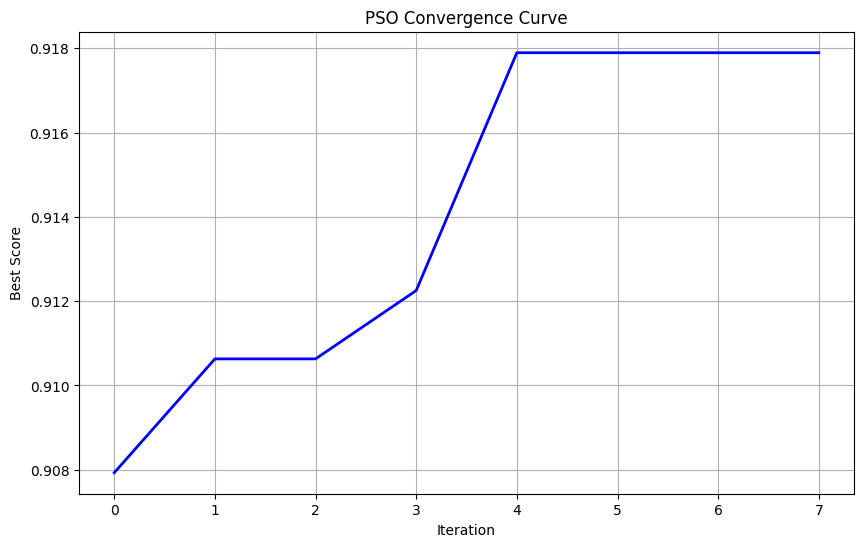


Testing weight strategy: frac_decay

--- Advanced PSO Iteration 1/8 ---
Adaptive params: w=2.100, c1=2.000, c2=1.000
Evaluating Particle 1: hidden=991, lr=0.000026, dropout=0.341, layers=3
  Score: 0.8507
Evaluating Particle 2: hidden=892, lr=0.000320, dropout=0.600, layers=2
  Score: 0.8954
Evaluating Particle 3: hidden=391, lr=0.003112, dropout=0.381, layers=3
  Score: 0.8971
Evaluating Particle 4: hidden=473, lr=0.006943, dropout=0.200, layers=3
  Score: 0.8827
Evaluating Particle 5: hidden=890, lr=0.000331, dropout=0.600, layers=2
  Score: 0.8953
Evaluating Particle 6: hidden=411, lr=0.003961, dropout=0.332, layers=3
  Score: 0.9036
Evaluating Particle 7: hidden=279, lr=0.000489, dropout=0.592, layers=2
  Score: 0.8869
Evaluating Particle 8: hidden=626, lr=0.009147, dropout=0.125, layers=2
  Score: 0.8954
Best so far: hidden=411, lr=0.003961, dropout=0.332, layers=3, score=0.9036

--- Advanced PSO Iteration 2/8 ---
Adaptive params: w=2.082, c1=1.875, c2=1.125
Evaluating Particle 1

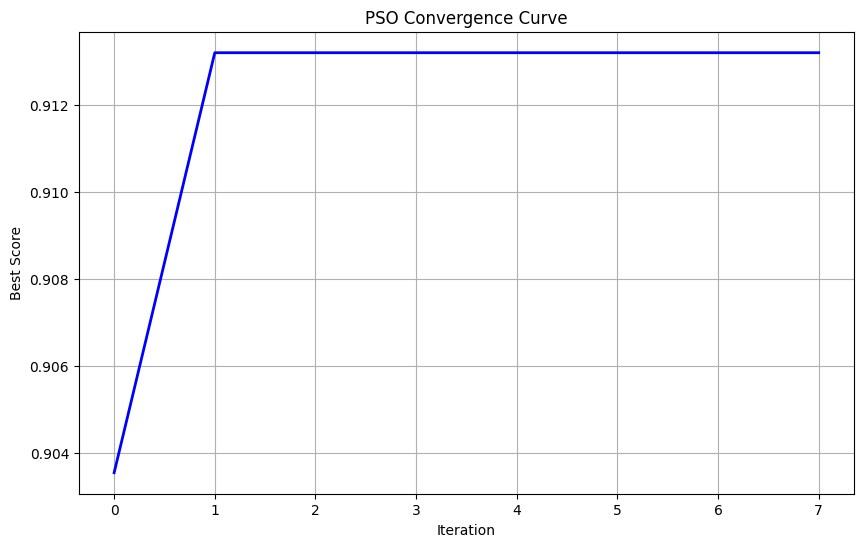


Testing weight strategy: triangle_osc

--- Advanced PSO Iteration 1/8 ---
Adaptive params: w=1.974, c1=2.000, c2=1.000
Evaluating Particle 1: hidden=543, lr=0.009642, dropout=0.110, layers=2
  Score: 0.8912
Evaluating Particle 2: hidden=444, lr=0.005520, dropout=0.257, layers=3
  Score: 0.8904
Evaluating Particle 3: hidden=650, lr=0.008242, dropout=0.154, layers=2
  Score: 0.8957
Evaluating Particle 4: hidden=197, lr=0.000072, dropout=0.509, layers=3
  Score: 0.7761
Evaluating Particle 5: hidden=1001, lr=0.000020, dropout=0.280, layers=3
  Score: 0.8334
Evaluating Particle 6: hidden=1011, lr=0.000015, dropout=0.203, layers=3
  Score: 0.8386
Evaluating Particle 7: hidden=753, lr=0.003379, dropout=0.365, layers=3
  Score: 0.8822
Evaluating Particle 8: hidden=608, lr=0.009646, dropout=0.110, layers=2
  Score: 0.8840
Best so far: hidden=650, lr=0.008242, dropout=0.154, layers=2, score=0.8957

--- Advanced PSO Iteration 2/8 ---
Adaptive params: w=2.011, c1=1.875, c2=1.125
Evaluating Partic

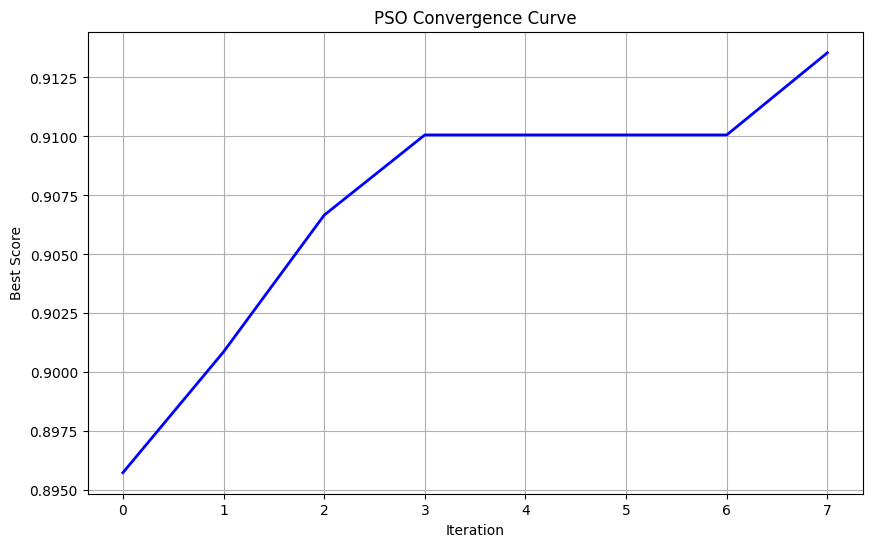


Performance Comparison of Different Strategies:
Strategy       Hidden  LR          Dropout   Layers  Accuracy
-----------------------------------------------------------------
exp_decay      8110.001274    0.516     2       0.9179
frac_decay     4470.002724    0.533     2       0.9132
triangle_osc   1280.010000    0.163     2       0.9135

Optimization Complete!
Best Strategy: exp_decay
Best Hyperparameters: hidden_dim=811, lr=0.001274, dropout=0.516, layers=2
Best Validation Accuracy: 0.9179


In [ ]:
# === Modify the PSO run section ===
print("Running advanced PSO optimization with chaotic maps...")

# Test different inertia weight strategies
weight_strategies = ['exp_decay', 'frac_decay', 'triangle_osc']
best_results = []

for strategy in weight_strategies:
    print(f"\n{'='*50}")
    print(f"Testing weight strategy: {strategy}")
    print(f"{'='*50}")

    best_params, best_acc = advanced_PSO(
        num_particles=8,    # Reduce number of particles to speed up
        max_iters=8,        # Reduce number of iterations
        use_chaos=True,
        use_levy=True,
        weight_type=strategy
    )

    best_results.append({
        'strategy': strategy,
        'params': best_params,
        'accuracy': best_acc
    })


print("\nPerformance Comparison of Different Strategies:")
print("Strategy".ljust(15) + "Hidden".ljust(8) + "LR".ljust(12) + "Dropout".ljust(10) + "Layers".ljust(8) + "Accuracy")
print("-" * 65)
for result in best_results:
    params = result['params']
    print(f"{result['strategy'].ljust(15)}"
          f"{int(params[0])}".ljust(8) +
          f"{params[1]:.6f}".ljust(12) +
          f"{params[2]:.3f}".ljust(10) +
          f"{int(params[3])}".ljust(8) +
          f"{result['accuracy']:.4f}")

# Select the best strategy
best_result = max(best_results, key=lambda x: x['accuracy'])
best_params = best_result['params']
best_acc = best_result['accuracy']

print(f"\nOptimization Complete!")
print(f"Best Strategy: {best_result['strategy']}")
print(f"Best Hyperparameters: hidden_dim={int(best_params[0])}, lr={best_params[1]:.6f}, dropout={best_params[2]:.3f}, layers={int(best_params[3])}")
print(f"Best Validation Accuracy: {best_acc:.4f}")

In [ ]:
print(f"\nTraining final model with optimized hyperparameters...")
hidden_dim, lr, dropout, num_layers = best_params

input_feature_size = train_features.shape[1]
final_model = EnhancedGNN(
    in_feats=input_feature_size,
    hidden=int(hidden_dim),
    num_classes=len(label_encoder.classes_),
    dropout=dropout,
    num_layers=int(num_layers)
)

# Use cosine annealing learning rate scheduler
final_optimizer = torch.optim.AdamW(final_model.parameters(), lr=lr, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(final_optimizer, T_max=20)
final_criterion = nn.CrossEntropyLoss()

# Improved early stopping strategy
best_val_acc = 0
patience = 8
no_improve = 0
min_epochs = 15

for epoch in range(50):
    train_loss = train_one_epoch(final_model, train_loader, final_optimizer, final_criterion)
    scheduler.step()  # Update learning rate
    val_acc = evaluate(final_model, valid_loader)

    current_lr = scheduler.get_last_lr()[0]
    print(f"Epoch {epoch+1:2d}, Train Loss={train_loss:.4f}, Val Acc={val_acc:.4f}, LR={current_lr:.6f}")

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        no_improve = 0
        torch.save(final_model.state_dict(), 'best_enhanced_model.pth')
    else:
        no_improve += 1
        if no_improve >= patience and epoch >= min_epochs:
            print(f"Early stopping at epoch {epoch+1}")
            break


Training final model with optimized hyperparameters...
Epoch  1, Train Loss=0.4964, Val Acc=0.9055, LR=0.001266
Epoch  2, Train Loss=0.3143, Val Acc=0.9160, LR=0.001243
Epoch  3, Train Loss=0.2677, Val Acc=0.9160, LR=0.001205
Epoch  4, Train Loss=0.2404, Val Acc=0.9283, LR=0.001152
Epoch  5, Train Loss=0.1859, Val Acc=0.9344, LR=0.001087
Epoch  6, Train Loss=0.1618, Val Acc=0.9388, LR=0.001011
Epoch  7, Train Loss=0.1319, Val Acc=0.9414, LR=0.000926
Epoch  8, Train Loss=0.1222, Val Acc=0.9449, LR=0.000834
Epoch  9, Train Loss=0.1008, Val Acc=0.9431, LR=0.000737
Epoch 10, Train Loss=0.0966, Val Acc=0.9493, LR=0.000637
Epoch 11, Train Loss=0.0893, Val Acc=0.9458, LR=0.000537
Epoch 12, Train Loss=0.0645, Val Acc=0.9563, LR=0.000440
Epoch 13, Train Loss=0.0539, Val Acc=0.9598, LR=0.000348
Epoch 14, Train Loss=0.0484, Val Acc=0.9554, LR=0.000263
Epoch 15, Train Loss=0.0470, Val Acc=0.9606, LR=0.000187
Epoch 16, Train Loss=0.0337, Val Acc=0.9606, LR=0.000122
Epoch 17, Train Loss=0.0340, Val

In [ ]:
# Load the best model and evaluate on the test set
final_model.load_state_dict(torch.load('best_enhanced_model.pth'))  # Load the saved best model
test_acc = evaluate(final_model, test_loader)  # Evaluate on the test set

# Print final results
print(f"\n" + "="*50)  # Separator line
print(f"FINAL RESULTS")  # Title
print(f"="*50)
print(f"Best Validation Accuracy: {best_val_acc:.4f}")  # Best validation accuracy
print(f"Final Test Accuracy: {test_acc:.4f}")  # Test set accuracy
print(f"Best Hyperparameters:")  # Best hyperparameters
print(f"  Hidden Dimensions: {int(best_params[0])}")  # Hidden layer dimension
print(f"  Learning Rate: {best_params[1]:.6f}")  # Learning rate
print(f"  Dropout: {best_params[2]:.3f}")  # Dropout rate
print(f"="*50)


FINAL RESULTS
Best Validation Accuracy: 0.9606
Final Test Accuracy: 0.9527
Best Hyperparameters:
  Hidden Dimensions: 811
  Learning Rate: 0.001274
  Dropout: 0.516


In [ ]:
# Import evaluation metrics
from sklearn.metrics import classification_report, confusion_matrix

def get_predictions(model, loader):
    """Obtain predictions and true labels from a data loader"""
    model.eval()  # Set model to evaluation mode
    all_preds = []   # Store all predicted results
    all_labels = []  # Store all true labels

    with torch.no_grad():  # Disable gradient calculation
        for batch in loader:
            out = model(batch.x, batch.edge_index, batch.batch)  # Forward pass
            preds = out.argmax(dim=1)  # Get predicted class
            all_preds.extend(preds.cpu().numpy())  # Convert to numpy and collect
            all_labels.extend(batch.y.cpu().numpy())  # Collect true labels

    return np.array(all_preds), np.array(all_labels)  # Return as arrays

# Get test set predictions
test_preds, test_true = get_predictions(final_model, test_loader)

# Print detailed classification report
print("Detailed Test Results:")
print(classification_report(
    test_true,
    test_preds,
    target_names=label_encoder.classes_,  # Use original class names
    digits=4  # Show 4 decimal places
))

# Confusion matrix
print("\nConfusion Matrix:")
cm = confusion_matrix(test_true, test_preds)  # Compute confusion matrix
print(cm)

Detailed Test Results:
              precision    recall  f1-score   support

      glioma     0.9738    0.8667    0.9171       300
  meningioma     0.8731    0.9444    0.9074       306
     notumor     0.9926    0.9975    0.9951       405
   pituitary     0.9673    0.9867    0.9769       300

    accuracy                         0.9527      1311
   macro avg     0.9517    0.9488    0.9491      1311
weighted avg     0.9546    0.9527    0.9526      1311


Confusion Matrix:
[[260  38   0   2]
 [  7 289   2   8]
 [  0   1 404   0]
 [  0   3   1 296]]


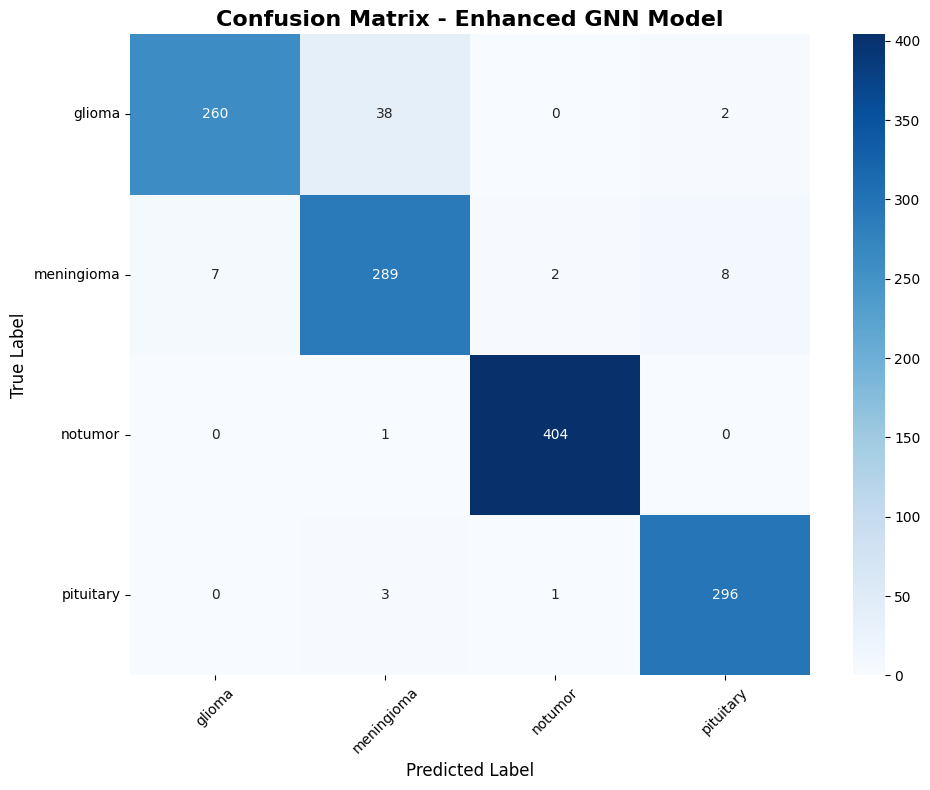

In [ ]:
# Confusion matrix heatmap
plt.figure(figsize=(10, 8))
cm = confusion_matrix(test_true, test_preds)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)
plt.title('Confusion Matrix - Enhanced GNN Model', fontsize=16, fontweight='bold')
plt.xlabel('Predicted Label', fontsize=12)
plt.ylabel('True Label', fontsize=12)
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.savefig('confusion_matrix.png', dpi=300, bbox_inches='tight')
plt.show()